In [6]:
import os
import sys

data_dirc = "data"

def progress_bar(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    s = str(count) + "/" + str(total)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s ...%s\r' % (bar, s, status))
    sys.stdout.flush() # As suggested by Rom Ruben (see: http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console/27871113#comment50529068_27871113)


FileNotFoundError: [Errno 2] No such file or directory: 'data/kmeans/3/299091.jpg'

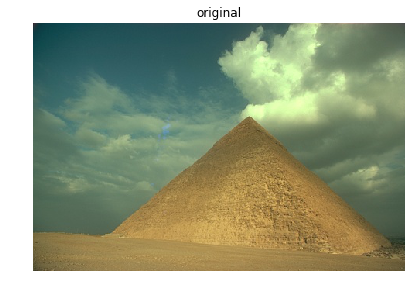

In [15]:
# display image and it's segmentation

from matplotlib.image import imread
import matplotlib.pyplot as plt

def visualize(image_name, original_path, segmentation_path, segs):

    img = imread(os.path.join(original_path, image_name))

    
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    
    l = len(segs) + 1
    n = 2
    m = l // n
    
    fig.add_subplot(n, m, 1)
    plt.axis('off')
    plt.title('original')
    plt.imshow(img)
    
    i = 2
    for f in segs:
        img = imread(os.path.join(segmentation_path, f, image_name))
        fig.add_subplot(n, m, i)
        plt.axis('off')
        plt.title('clusters: ' + f)
        plt.imshow(img)
        
        i = i + 1
        
#     plot(img)
    plt.show()

dirc_train = os.path.join(data_dirc, "train")
dirc_kmeans = os.path.join(data_dirc, "kmeans")
pyramid_image = "299091.jpg"
# visualize(pyramid_image, dirc_train, dirc_kmeans, ["3", "5", "7", "9", "11"])




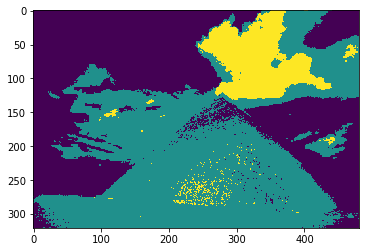

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [19]:
# kmeans

from sklearn.cluster import KMeans

def kmeans_cluster(img, n_clusters):
    
    n = img.shape[0]
    m = img.shape[1]
    colors = img.shape[2]
    
    img = img.reshape(n * m, colors) # n * m rows each with a vector of RGB
    kmeans = KMeans(n_clusters=n_clusters, precompute_distances=True, n_jobs=-1).fit(img)
    
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
#     for i in range(0, n * m):
#         img[i] = centers[labels[i]]
    
    labels = labels.reshape(n, m)
    return labels


    
img = imread(os.path.join(dirc_train, pyramid_image))
img.flags.writeable = True
result = kmeans_cluster(img, 3)
plt.imshow(result)
plt.show()
print(result)







In [20]:
import numpy as np
import imageio

def kmeans_images(original_path, result_path, segs):
    print("processing images in " + original_path + " writing result to " + result_path +
         " for clusters " + str(segs))
    
    images = os.listdir(original_path)
    n = len(images)
    i = 1
    for image in images:
        progress_bar(i, n, image)
        i = i + 1
        
        img = imread(os.path.join(original_path, image))
        for seg in segs:
            dirc = os.path.join(result_path, str(seg))
            if not os.path.exists(dirc):
                os.makedirs(dirc)
                
            c = numpy.copy(img)
            result = kmeans_cluster(c, seg)
            np.save(os.path.join(dirc, image), result)
        
    print("kmeans done")

n_tirals = 1
for i in range(1, n_tirals + 1):
    print("run number: " + str(i))
    f = "run_" + str(i)
    kmeans_images(dirc_train, os.path.join(dirc_kmeans, f), [3,5,7,9,11])








run number: 1
processing images in data/train writing result to data/kmeans/run_1 for clusters [3, 5, 7, 9, 11]


KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: 'data/kmeans/run_1/3/299091.jpg'

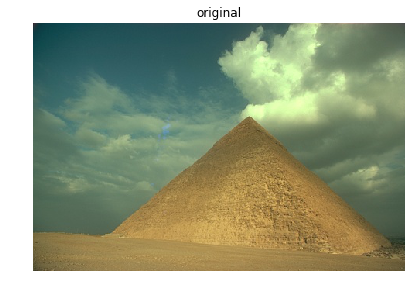

In [11]:

visualize(pyramid_image, dirc_train, os.path.join(dirc_kmeans, "run_1"), ["3", "5", "7", "9", "11"])


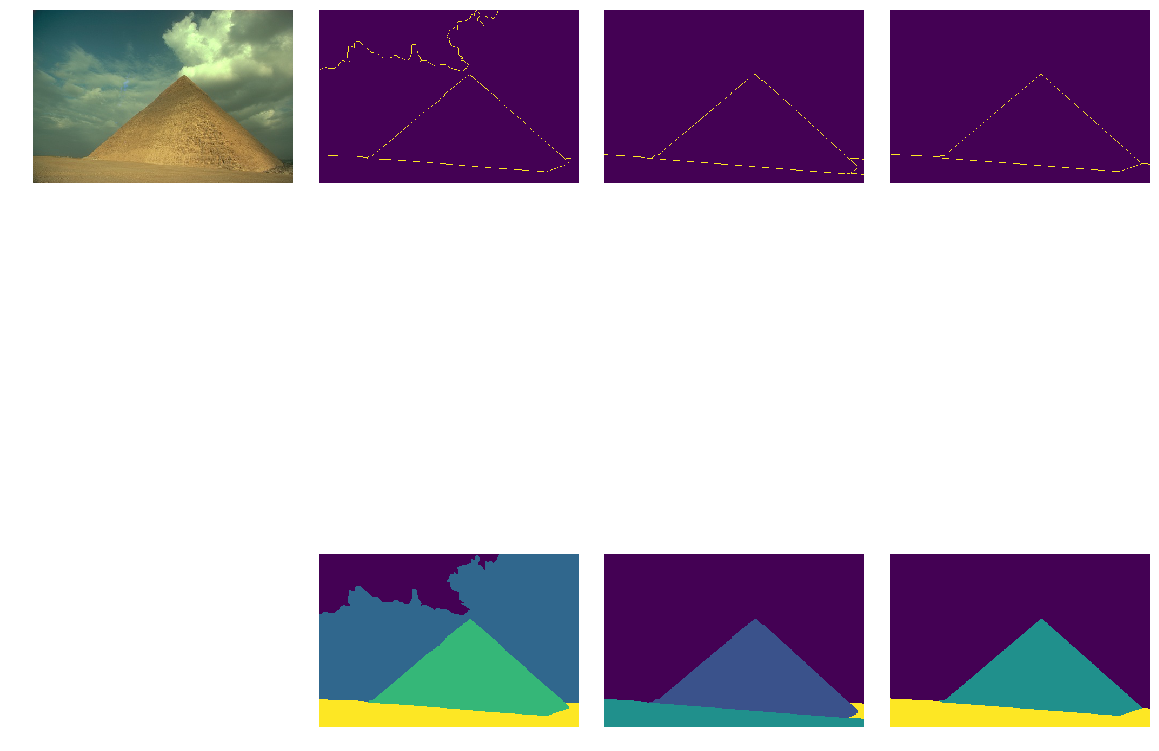

In [12]:
import scipy.io
dirc_truth = os.path.join(data_dirc, 'groundTruth')

def show_image_groundTrue(image_path):
    
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(hspace=0.0, wspace=0.1)
    n = 2
    m = 4
    j = 1
    img = imread(os.path.join(data_dirc, image_path))
    fig.add_subplot(n, m, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img)
    
    image_path = image_path.replace('jpg', 'mat')
    mat = scipy.io.loadmat(os.path.join(dirc_truth, image_path))
    
    for i in range(0, 3):
        x = mat['groundTruth'][0][i][0][0][1]
        fig.add_subplot(n, m, j)
        plt.axis('off')
        plt.imshow(x)
        j = j + 1

    j = j + 1
    for i in range(0, 3):
        x = mat['groundTruth'][0][i][0][0][0]
        fig.add_subplot(n, m, j)
        plt.axis('off')
        plt.imshow(x)
        j = j + 1

    plt.show()

show_image_groundTrue(os.path.join('train', pyramid_image))


In [13]:
# F-measure


def cluster_freq(clusters, truth):
    freq = {}
    g = {}
    for c, t in zip(clusters, truth):
        if not c in freq:
            freq[c] = {}
        
        if not t in freq[c]:
            freq[c][t] = 0
        
        freq[c][t] = freq[c][t] + 1
        
        if not t in g:
            g[t] = 0
        g[t] = g[t] + 1
        
    return (freq, g)


# clusters and truth are two dimention arrays
def f_measure(clusters, truth):
    
    (n, m) = clusters.shape
    clusters = clusters.reshape(n * m)
    truth = truth.reshape(n * m)
    # map of cluster id (from clusters) to a map of cluster id (from truth)
    # and it's frequency
    (freq, g) = cluster_freq(clusters, truth)
    
    f_score = 0
    n = 0
    for k, v in freq.items(): # for each cluster
        total = 0
        max_index = -1
        max_count = -1
        
        for a, f in v.items():
            total = total + f
            if(f > max_count):
                max_count = f
                max_index = a
                
        prec = max_count * 1.0 / total
        rec = max_count / g[max_index]
        
        f = 2.0 * (prec * rec) / (prec + rec)
        f_score = f_score + f
        
        n = n + 1
        
    f_score = f_score / n
    
    return f_score
    
img = np.load(os.path.join(dirc_kmeans, "run_1", "11", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))

plt.imshow(img)
plt.show()

f = f_measure(img, mat['groundTruth'][0][0][0][0][0])
print(f)



FileNotFoundError: [Errno 2] No such file or directory: 'data/kmeans/run_1/11/299091.jpg.npy'

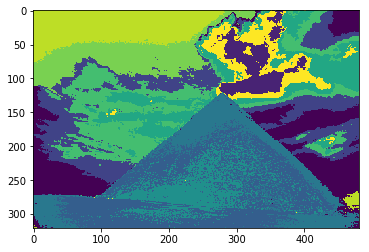

0.0316288460791


In [340]:
#  Conditional Entropy

# clusters and truth are two dimention arrays
import math
def conditional_entropy(clusters, truth):

    (n, m) = clusters.shape
    size = n * m * 1.0
    
    clusters = clusters.reshape(n * m)
    truth = truth.reshape(n * m)
    
    (freq, g) = cluster_freq(clusters, truth)
    
    ht = 0
    
    for k, v in freq.items():
        t = 0.0 # total elements in cluster
        for a, b in v.items():
            t = t + b
        
        x = 0
        for a, b in v.items():
    
            l = - b / t * log(b / t)
            x = x + l
        
        ht = x * t / size
    
    return ht
    

img = np.load(os.path.join(dirc_kmeans, "run_1", "11", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))

plt.imshow(img)
plt.show()

f = conditional_entropy(img, mat['groundTruth'][0][0][0][0][0])
print(f)





In [348]:



# image id | f measure                       || conditional entropy
#          | 1     | 2     | average  ||  worest    | best      | average
#          | value |id | value|  value   ||id  | value |id | value | value



import csv

csvData = [['Person', 'Age'], ['Peter', '22'], ['Jasmine', '21'], ['Sam', '24']]

with open('person.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()



